# Machine learning to predict energy consumption

## Introduction research

Energy transition is an important concept in today's society. Which also makes green energy generation very popular in the Netherlands. The top five most generating days with green energy also all took place in 2022. Unfortunately, there is also a downside to these spikes in energy production. Energy producers pay more for green energy towards the grid and grid operators have to pay a lot for huge peaks and troughs in the Netherlands' electricity grid. Besides this year has already seen five record spikes in green energy production. Alerts have also been issued by Tennet (manages high-voltage grid in the Netherlands) four times this year (Van Weezel, 2022). 

So for both energy production companies and grid operators, it is very important to avoid these peaks and troughs. One way to do this is to forecast energy consumption (TNO, 2021). In this notebook, this is done based on a number of features. 

### The features for the prediction

The first feature is inflation. This is done because there is a strong link between inflation and buyer strength. Buyers strenght can decrease due to inflation. This is because a rising price level means that fewer products and services can be bought. Inflation and purchasing power affect the whole economy, from consumers to businesses (Hayes, 2022). Because of this relationship, inflation also affects long-term investment. Recently, energy prices have been rising rapidly the government also sees the link between sustained inflation, rising energy prices and falling purchasing power. Only to what extent does this relationship also affect energy consumption in the Netherlands and is there a relationship between the two (Tweede Kamer, 2022)?

The second feature is sunhours. First of all, sunshine hours means the total sunshine hours on a day in the Netherlands expressed in hours. In the Netherlands, there is a clear difference in the number of sunshine hours in summer and winter. In summer, the average number of sunshine hours is between 6 and 7 hours a day, while in winter it is 2 hours. Because there is less daylight in winter and it is more often cloudy in winter, the average is lower (Dirk Wolters, 2011).

When there are fewer sunlight hours, it means it is darker. As a result, people have to use energy more often (Visser, 2014) to provide themselves with light, by turning on lamps, for example. The number of sunshine hours also affects the use of green energy by solar panels. In summer, there are more hours of sunshine, so a lot of green energy can be generated. However, this will be used less because energy demand is higher in winter. It costs a lot of money to store solar energy to use later, which is therefore not done in households, for example. As a result, there is a higher peak energy consumption on the grid in winter (Visser, 2014).

The third feature is wind strenght. Wind force data are in FHEV. Vector average wind force of the day. The vector mean is the average of all vectors where the wind was blowing and how hard. If two vectors are exactly opposite each other, they cancel each other out and so does the wind force of the day. It is thus the average wind force in a given direction (KNMI, s.d.). Because of the large growth envisaged by the Netherlands in the use of wind energy as an energy source, this has also been included as a characteristic (Rijksoverheid, 2022).

The fourth characteristic is temperature. In a year where the average temperature is higher, energy consumption is lower. In a year where the temperature is lower, energy consumption is higher. This also means that the price of energy is higher, which has an important relationship with inflation (the first characteristic) (Het Weer, 2022). 

## Import packages

In [1]:
import pandas as pd
import numpy as np
import scipy.stats

import random as rnd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Clean and prepare the datasets

A major drawback of this study is that only monthly energy data are available for the whole of the Netherlands. As a result, the other data also used in this study had to be converted into monthly data. But the second major drawback is that in another study on energy pridiction, the dataset of daily data was the most important thing in the study (Ding, 2020). The reason for including certain data is explained in more detail in the paper.

The legend describes the different characteristics of the dataset. The legend can be found at the bottom of the notebook. 

### Import the datasets

The dataset inflation_Netherlands is a dataset created in another Notebook. This Notebook is available on my Github page: https://github.com/riksmink/HCAI. The other datasets are from: https://www.daggegevens.knmi.nl/klimatologie/daggegevens. 

In [2]:
inflation_Netherlands = pd.read_csv("Inflationfile.csv", skiprows = range(265, 273), index_col = False)
energy_consumption = pd.read_csv("MontlyEnergy.csv", skiprows = range(265, 273), index_col = 0)
sun_hours = pd.read_csv("zonuren1.csv", index_col = False)
temperature = pd.read_csv("Dataset_temperatuur.csv", skiprows = range(265, 274), index_col = False)
wind_mode = pd.read_csv("WeatherMontlyMode.csv", skiprows = range(265, 275), index_col = False)
wind_mean = pd.read_csv("WeatherMontlyAverage.csv", skiprows = range(265, 275), index_col = False)

### Work with the columns on the datasets

The first problem with the datasets is that there are different ways to write dates in the data. The second problem is that not all column names are in English. The third problem was that there were several columns that were not attributes for the ML model, so they were removed from the dataset. The reason for the removal of those columns is in another notebook. You can find this notebook at https://github.com/riksmink/HCAI. 

#### Make a common date column

In [3]:
# Inflation dataset
import locale

# The months are in Netherlands in the dataset
locale.setlocale(locale.LC_ALL, "nl_NL")

inflation_Netherlands['Perioden'] = pd.to_datetime(inflation_Netherlands['Perioden'], format='%Y %B').apply(lambda date: date.strftime(format='%Y-%m'))

# Energy consumption dataset
energy_consumption['Perioden'] = pd.to_datetime(energy_consumption['Perioden'], format='%YMM%m').apply(lambda date: date.strftime(format='%Y-%m'))

# Sun hours dataset
sun_hours['Datum'] = pd.to_datetime(sun_hours['Datum'], format='%Y-%m').apply(lambda date: date.strftime(format='%Y-%m'))

# Temperature dataset
temperature['DateTime'] = pd.to_datetime(temperature['DateTime'], format='%Y-%m').apply(lambda date: date.strftime(format='%Y-%m'))

# Wind datasets
wind_mode['YYYYMMDD'] = pd.to_datetime(wind_mode['YYYYMMDD'], format='%Y-%m').apply(lambda date: date.strftime(format='%Y-%m'))
wind_mean['YYYYMMDD'] = pd.to_datetime(wind_mean['YYYYMMDD'], format='%Y-%m').apply(lambda date: date.strftime(format='%Y-%m'))

#### Rename the columns

In [4]:
# Inflation dataset
inflation_Netherlands01 = inflation_Netherlands.rename(columns={'Perioden': 'Date', 'CPI_energie' : 'CPI_energy', 'CPI_algemeen': 'CPI_general','CPI(afgeleid)_energie ' : 'CPI_energyderived',})

# Energy consumption dataset
energy_consumption01 = energy_consumption.rename(columns={'Perioden': 'Date', 'NettoVerbruikBerekend_30' : 'Energyconsumption'})

# Sun hours dataset
sun_hours01 = sun_hours.rename(columns={'Datum': 'Date', 'zonuren_dag' : 'Sunhoursdaily'})

# Temperature dataset
temperature01 = temperature.rename(columns={'DateTime': 'Date'})

# Wind datasets
wind_mode01 = wind_mode.rename(columns={'YYYYMMDD': 'Date'})
wind_mean01 = wind_mean.rename(columns={'YYYYMMDD': 'Date'})


#### Drop some columns

In [5]:
# Inflation dataset
inflation_Netherlands02 = inflation_Netherlands01.drop(['Jaar', 'Maand', 'CPI_energie-100', 'CPI_energiejaarlijks', 'CPI(algemeen)_afgeleid', 'CPI_elektriciteit', 'CPI(elektriciteit)_afgeleid', 'CPI(gas)_afgeleid'], axis=1)

# Energy dataset
energy_consumption02 = energy_consumption01.drop(['ID'], axis=1)

# Temperature dataset
temperature02 = temperature01.drop(['Unnamed: 0'], axis=1)

### Merge the datasets and prepare for machine learning

The preparation for merging is done. Now the datasets are prepared for training the models for machine learning.  Time series is very important because the model is gonna predict a continuous variable in the feature (Knaub, 2015). 

#### Merge the datasets

In [6]:
# merge all the dataframes
ml_datasetenergy = inflation_Netherlands02.merge(energy_consumption02, on='Date', how='left').merge(sun_hours01, on='Date', how='left').merge(temperature02, on='Date', how='left').merge(wind_mode01, on='Date', how='left').merge(wind_mean01, on='Date', how='left')

ml_datasetenergy.head()

,Date,CPI_energy,CPI_energyderived,CPI_general,CPI_gas,Energyconsumption,Sunhoursdaily,TG,TN,TX,FG_x,FG_y
0,2000-01,52.22,65.20,73.55,43.70,8847,1.806452,4.329032,1.729032,6.561290,4.0,4.219355
1,2000-02,52.29,65.28,74.00,43.69,8235,3.682759,5.855172,2.537931,8.941379,4.6,4.748276
2,2000-03,52.73,65.84,74.66,43.62,8738,2.583871,6.796774,3.361290,10.112903,1.5,3.980645
3,2000-04,52.74,65.85,74.78,43.62,7912,5.116667,9.986667,5.186667,14.753333,1.9,3.553333
4,2000-05,52.74,65.85,75.02,43.62,8221,6.780645,14.732258,9.274194,20.022581,3.8,3.496774


#### Make extra columns for time series

The prediction is done over time, so the dataset must be different. It starts at 2 months because otherwise it is impossible to do all the calculations on the first day of each month. This must be done because the prediction is made over time. The choice of the 1 year, 2 months is because of the weather features (Knaub, 2015).

In [7]:
# Copy the date column and make a new one

# 2 months
ml_datasetenergy ['CPI_energy2month'] = ml_datasetenergy ['CPI_energy']
ml_datasetenergy ['Sunhoursdaily2month'] = ml_datasetenergy ['Sunhoursdaily']
ml_datasetenergy ['TG2month'] = ml_datasetenergy ['TG']
ml_datasetenergy ['TX2month'] = ml_datasetenergy ['TG']
ml_datasetenergy ['TN2month'] = ml_datasetenergy ['TN']
ml_datasetenergy ['FG_x2month'] = ml_datasetenergy ['FG_x']
ml_datasetenergy ['FG_y2month'] = ml_datasetenergy ['FG_y']

# 3 months
ml_datasetenergy ['CPI_energy3month'] = ml_datasetenergy ['CPI_energy']
ml_datasetenergy ['Sunhoursdaily3month'] = ml_datasetenergy ['Sunhoursdaily']
ml_datasetenergy ['TG3month'] = ml_datasetenergy ['TG']
ml_datasetenergy ['TX3month'] = ml_datasetenergy ['TX']
ml_datasetenergy ['TN3month'] = ml_datasetenergy ['TN']
ml_datasetenergy ['FG_x3month'] = ml_datasetenergy ['FG_x']
ml_datasetenergy ['FG_y3month'] = ml_datasetenergy ['FG_y']

# 6 months
ml_datasetenergy ['CPI_energy6month'] = ml_datasetenergy ['CPI_energy']
ml_datasetenergy ['Sunhoursdaily6month'] = ml_datasetenergy ['Sunhoursdaily']
ml_datasetenergy ['TG6month'] = ml_datasetenergy ['TG']
ml_datasetenergy ['TX6month'] = ml_datasetenergy ['TX']
ml_datasetenergy ['TN6month'] = ml_datasetenergy ['TN']
ml_datasetenergy ['FG_x6month'] = ml_datasetenergy ['FG_x']
ml_datasetenergy ['FG_y6month'] = ml_datasetenergy ['FG_y']

# 1 year
ml_datasetenergy ['CPI_energy1year'] = ml_datasetenergy ['CPI_energy']
ml_datasetenergy ['Sunhoursdaily1year'] = ml_datasetenergy ['Sunhoursdaily']
ml_datasetenergy ['TG1year'] = ml_datasetenergy ['TG']
ml_datasetenergy ['TX1year'] = ml_datasetenergy ['TX']
ml_datasetenergy ['TN1year'] = ml_datasetenergy ['TN']
ml_datasetenergy ['FG_x1year'] = ml_datasetenergy ['FG_x']
ml_datasetenergy ['FG_y1year'] = ml_datasetenergy ['FG_y']

# Move the rows in the column

# 2 months
ml_datasetenergy ['CPI_energy2month'] = ml_datasetenergy ['CPI_energy2month'].shift(+2)
ml_datasetenergy ['Sunhoursdaily2month'] = ml_datasetenergy ['Sunhoursdaily2month'].shift(+2)
ml_datasetenergy ['TG2month'] = ml_datasetenergy ['TG2month'].shift(+2)
ml_datasetenergy ['TX2month'] = ml_datasetenergy ['TX2month'].shift(+2)
ml_datasetenergy ['TN2month'] = ml_datasetenergy ['TN2month'].shift(+1)
ml_datasetenergy ['FG_x2month'] = ml_datasetenergy ['FG_x2month'].shift(+2)
ml_datasetenergy ['FG_y2month'] = ml_datasetenergy ['FG_y2month'].shift(+2)

# 3 month
ml_datasetenergy ['CPI_energy3month'] = ml_datasetenergy ['CPI_energy3month'].shift(+3)
ml_datasetenergy ['Sunhoursdaily3month'] = ml_datasetenergy ['Sunhoursdaily3month'].shift(+3)
ml_datasetenergy ['TG3month'] = ml_datasetenergy ['TG3month'].shift(+3)
ml_datasetenergy ['TX3month'] = ml_datasetenergy ['TX3month'].shift(+3)
ml_datasetenergy ['TN3month'] = ml_datasetenergy ['TN3month'].shift(+3)
ml_datasetenergy ['FG_x3month'] = ml_datasetenergy ['FG_x3month'].shift(+3)
ml_datasetenergy ['FG_y3month'] = ml_datasetenergy ['FG_y3month'].shift(+3)

# 6 month
ml_datasetenergy ['CPI_energy6month'] = ml_datasetenergy ['CPI_energy6month'].shift(+6)
ml_datasetenergy ['Sunhoursdaily6month'] = ml_datasetenergy ['Sunhoursdaily6month'].shift(+6)
ml_datasetenergy ['TG6month'] = ml_datasetenergy ['TG6month'].shift(+6)
ml_datasetenergy ['TX6month'] = ml_datasetenergy ['TX6month'].shift(+6)
ml_datasetenergy ['TN6month'] = ml_datasetenergy ['TN6month'].shift(+6)
ml_datasetenergy ['FG_x6month'] = ml_datasetenergy ['FG_x6month'].shift(+6)
ml_datasetenergy ['FG_y6month'] = ml_datasetenergy ['FG_y6month'].shift(+6)

# 1 year
ml_datasetenergy ['CPI_energy1year'] = ml_datasetenergy ['CPI_energy1year'].shift(+12)
ml_datasetenergy ['Sunhoursdaily1year'] = ml_datasetenergy ['Sunhoursdaily1year'].shift(+12)
ml_datasetenergy ['TG1year'] = ml_datasetenergy ['TG1year'].shift(+12)
ml_datasetenergy ['TX1year'] = ml_datasetenergy ['TX1year'].shift(+12)
ml_datasetenergy ['TN1year'] = ml_datasetenergy ['TN1year'].shift(+12)
ml_datasetenergy ['FG_x1year'] = ml_datasetenergy ['FG_x1year'].shift(+12)
ml_datasetenergy ['FG_y1year'] = ml_datasetenergy ['FG_y1year'].shift(+12)

In [8]:
# The target variable as feature for ml-model

# 2, 3 and 6 months and 1 year
ml_datasetenergy ['Energyconsumption2month'] = ml_datasetenergy ['Energyconsumption']
ml_datasetenergy ['Energyconsumption3month'] = ml_datasetenergy ['Energyconsumption']
ml_datasetenergy ['Energyconsumption6month'] = ml_datasetenergy ['Energyconsumption']
ml_datasetenergy ['Energyconsumption1year'] = ml_datasetenergy ['Energyconsumption']

# Move the rows in the column
ml_datasetenergy ['Energyconsumption2month'] = ml_datasetenergy ['Energyconsumption2month'].shift(+1)
ml_datasetenergy ['Energyconsumption3month'] = ml_datasetenergy ['Energyconsumption3month'].shift(+3)
ml_datasetenergy ['Energyconsumption6month'] = ml_datasetenergy ['Energyconsumption6month'].shift(+6)
ml_datasetenergy ['Energyconsumption1year'] = ml_datasetenergy ['Energyconsumption1year'].shift(+12)

In [9]:
# Make a new dataframe without the NAN values
ml_datasetenergy01 = ml_datasetenergy.copy()
ml_datasetenergy01 = ml_datasetenergy01.drop(labels=range(0,12), axis=0)

ml_datasetenergy01.columns = ml_datasetenergy01.columns.str.strip()

ml_datasetenergy01.head()

,Date,CPI_energy,CPI_energyderived,CPI_general,CPI_gas,Energyconsumption,Sunhoursdaily,TG,TN,TX,...,Sunhoursdaily1year,TG1year,TX1year,TN1year,FG_x1year,FG_y1year,Energyconsumption2month,Energyconsumption3month,Energyconsumption6month,Energyconsumption1year
12,2001-01,62.13,70.56,76.31,51.19,9267,2.312903,2.606452,0.025806,5.332258,...,1.806452,4.329032,6.561290,1.729032,4.0,4.219355,8844.0,8749.0,8006.0,8847.0
13,2001-02,62.13,70.56,76.98,51.19,8266,3.260714,4.467857,1.153571,7.792857,...,3.682759,5.855172,8.941379,2.537931,4.6,4.748276,9267.0,8892.0,8119.0,8235.0
14,2001-03,62.13,70.56,77.70,51.19,8962,2.041935,4.945161,1.835484,8.032258,...,2.583871,6.796774,10.112903,3.361290,1.5,3.980645,8266.0,8844.0,8217.0,8738.0
15,2001-04,60.14,68.11,78.13,51.02,8156,4.830000,8.283333,4.090000,12.580000,...,5.116667,9.986667,14.753333,5.186667,1.9,3.553333,8962.0,9267.0,8749.0,7912.0
16,2001-05,60.14,68.11,78.39,51.02,8304,8.941935,14.141935,8.522581,19.358065,...,6.780645,14.732258,20.022581,9.274194,3.8,3.496774,8156.0,8266.0,8892.0,8221.0


#### Split the 'Date' column in a in a year and month column

In [10]:
# Split the date column in year and month columns because some ML-models work better that way 
ml_datasetenergy01[["Year", "Month"]] = ml_datasetenergy01["Date"].str.split("-", expand = True)

# Make the year and month columns digits
ml_datasetenergy01 ['Year'] = ml_datasetenergy01['Year'].str.extract('(\d+)', expand=False).astype(int)
ml_datasetenergy01 ['Month'] = ml_datasetenergy01['Month'].str.extract('(\d+)', expand=False).astype(int)

# Copy
ml_datasetenergy02 = ml_datasetenergy01.copy()

ml_datasetenergy02.head()

,Date,CPI_energy,CPI_energyderived,CPI_general,CPI_gas,Energyconsumption,Sunhoursdaily,TG,TN,TX,...,TX1year,TN1year,FG_x1year,FG_y1year,Energyconsumption2month,Energyconsumption3month,Energyconsumption6month,Energyconsumption1year,Year,Month
12,2001-01,62.13,70.56,76.31,51.19,9267,2.312903,2.606452,0.025806,5.332258,...,6.561290,1.729032,4.0,4.219355,8844.0,8749.0,8006.0,8847.0,2001,1
13,2001-02,62.13,70.56,76.98,51.19,8266,3.260714,4.467857,1.153571,7.792857,...,8.941379,2.537931,4.6,4.748276,9267.0,8892.0,8119.0,8235.0,2001,2
14,2001-03,62.13,70.56,77.70,51.19,8962,2.041935,4.945161,1.835484,8.032258,...,10.112903,3.361290,1.5,3.980645,8266.0,8844.0,8217.0,8738.0,2001,3
15,2001-04,60.14,68.11,78.13,51.02,8156,4.830000,8.283333,4.090000,12.580000,...,14.753333,5.186667,1.9,3.553333,8962.0,9267.0,8749.0,7912.0,2001,4
16,2001-05,60.14,68.11,78.39,51.02,8304,8.941935,14.141935,8.522581,19.358065,...,20.022581,9.274194,3.8,3.496774,8156.0,8266.0,8892.0,8221.0,2001,5


### Save the dataset as a 'csv file'

In [11]:
ml_datasetenergy02.to_csv('datasetenergyprediction')

## Visualate the relations in the dataset

Visualising data is very important. This is because it allows, for instance, patterns or outliers in the dataset to become visible. Which in turn allows certain trends to be visualised (Tableau, s.d.). An important part of the study was to demonstrate the relationship between trends and energy consumption. This is done based on correlation calculations and these are also made visible in a scatterplot. 

### Scatterplot with random column

Run the next cell again for another plot with a different column (feature) from the dataset. The scatterplot shows the relationship between a random feature and the target variable. 

#### The visualisation

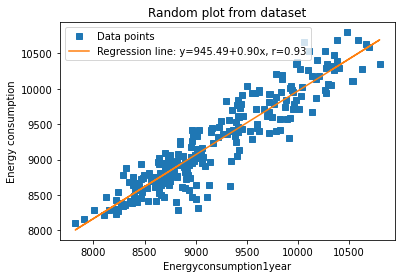

In [12]:
# Make a random column generator
rnd_col= rnd.choice(ml_datasetenergy02.columns)

# Give the x and y
x = ml_datasetenergy02[rnd_col]
y = ml_datasetenergy02['Energyconsumption']

# Make a regression line from the Pearson correlation coefficient
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)

# Relation between the regression line and the value of the correlation coefficient
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
line

# Make the plot
fig, ax = plt.subplots()

ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel(rnd_col)
ax.set_ylabel('Energy consumption')
ax.legend(facecolor='white')

plt.title("Random plot from dataset")
plt.show()

## Machine learning

Regression models are used for prediction for two reasons. Regression is necessary because the target variable is continuous. It is also not possible to create a neural network because it is a black box and cannot say anything about the characteristics which was a key requirement of the client (Ying, 2021). 

### Prediction based on the energyconsumption of the year before (no machine learning)

The first thing to try is to predict only on the basis of the energy consumption of that year before and on that what it deviates in kwh on average. This in fact means that the ML model has to predict better than this deviation, otherwise it is better to predict purely based on the energy data from that year before. 

#### Calculation 

In [13]:
# Make dataframes of the months
january_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 1]
february_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 2]
march_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 3]
april_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 4]
may_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 5]
june_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 6]
july_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 7]
august_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 8]
september_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 9]
october_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 10]
november_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 11]
december_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 12]


# Calculate the mean
january_prediction01 = np.mean(np.sqrt((january_prediction['Energyconsumption'] - january_prediction['Energyconsumption1year'])**2))
february_prediction01 = np.mean(np.sqrt((february_prediction['Energyconsumption'] - february_prediction['Energyconsumption1year'])**2))
march_prediction01 = np.mean(np.sqrt((march_prediction['Energyconsumption'] - march_prediction['Energyconsumption1year'])**2))
april_prediction01 = np.mean(np.sqrt((april_prediction['Energyconsumption'] - april_prediction['Energyconsumption1year'])**2))
may_prediction01 = np.mean(np.sqrt((may_prediction['Energyconsumption'] - may_prediction['Energyconsumption1year'])**2))
june_prediction01 = np.mean(np.sqrt((june_prediction['Energyconsumption'] - june_prediction['Energyconsumption1year'])**2))
july_prediction01 = np.mean(np.sqrt((july_prediction['Energyconsumption'] - july_prediction['Energyconsumption1year'])**2))
august_prediction01 = np.mean(np.sqrt((august_prediction['Energyconsumption'] - august_prediction['Energyconsumption1year'])**2))
september_prediction01 = np.mean(np.sqrt((september_prediction['Energyconsumption'] - september_prediction['Energyconsumption1year'])**2))
october_prediction01 = np.mean(np.sqrt((october_prediction['Energyconsumption'] - october_prediction['Energyconsumption1year'])**2))
november_prediction01 = np.mean(np.sqrt((november_prediction['Energyconsumption'] - november_prediction['Energyconsumption1year'])**2))
december_prediction01 = np.mean(np.sqrt((december_prediction['Energyconsumption'] - december_prediction['Energyconsumption1year'])**2))

# Make an dataframe of the total mean
total_mean = [january_prediction01, february_prediction01, march_prediction01, april_prediction01, may_prediction01, june_prediction01, july_prediction01, august_prediction01, september_prediction01, october_prediction01, november_prediction01, december_prediction01]

# Make a mean of all the predictions
prediction_based_on_last_year = sum(total_mean)/12

prediction_based_on_last_year

198.24603174603178

#### Conclusion prediction based on last year

The mean squared error of the model should be less than 198.25. This means that the model is better than a simple prediction based on the previous year. The best month to predict based on the previous year is September. The worst month is January. 

### Feature selection for the  regression model

A paper on effective features to predict energy consumption says that a key input for machine learning models to predict energy consumption is feature selection. This improves prediction performance and it helps researchers better understand the underlying process (Zhao, 2019).

#### Correlation feature selection

The machine learning models choice is regression (Ying, 2021). In most regression models, the correlation between the target variable and the characteristics is important. The stronger the correlation, the stronger the model. Therefore, a correlation characteristic is selected first. A higher score means a stronger correlation with the target variable (Brownlee, 2020). 

Feature 0: 19.395095
Feature 1: 124.939985
Feature 2: 107.228075
Feature 3: 127.563694
Feature 4: 79.536614
Feature 5: 2.293997
Feature 6: 35.522787
Feature 7: 13.339460
Feature 8: 32.806360
Feature 9: 1.093218
Feature 10: 1.093218
Feature 11: 25.823847
Feature 12: 0.390140
Feature 13: 0.195177
Feature 14: 10.563973
Feature 15: 0.557879
Feature 16: 14.649105
Feature 17: 11.488363
Feature 18: 22.584469
Feature 19: 1.918701
Feature 20: 11.343410
Feature 21: 15.018424
Feature 22: 98.775683
Feature 23: 127.543926
Feature 24: 126.755391
Feature 25: 111.220456
Feature 26: 0.940306
Feature 27: 26.642842
Feature 28: 94.385353
Feature 29: 1.794539
Feature 30: 39.095117
Feature 31: 954.061777


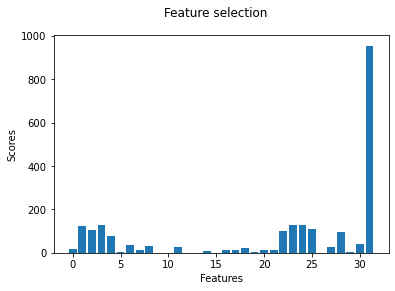

In [14]:
# Import new packages 
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# Make a x and y from the dataset
x = ml_datasetenergy02[['CPI_energy1year', 'Sunhoursdaily1year', 'TG1year', 'TX1year', 'TN1year','FG_x1year','FG_y1year', 'CPI_energy2month', 'Sunhoursdaily2month', 'TG2month', 'TX2month', 'TN2month', 'FG_x2month', 'FG_y2month', 'CPI_energy3month', 'Sunhoursdaily3month', 'TG3month', 'TX3month', 'TN3month', 'FG_x3month', 'FG_y3month', 'CPI_energy6month', 'Sunhoursdaily6month', 'TG6month', 'TX6month', 'TN6month', 'FG_x6month', 'FG_y6month','Energyconsumption2month', 'Energyconsumption3month', 'Energyconsumption6month','Energyconsumption1year']]
y = ml_datasetenergy02['Energyconsumption']

# Split the dataset in training- and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

# Make the regressionmodel 
regressionmodel = LinearRegression()
regressionmodel.fit(x_train, y_train)

# Define the feature selection 
def select_features(x_train, y_train, x_test):
    future_selection = SelectKBest(score_func=f_regression, k='all') # Get all the features
    future_selection.fit(x_train, y_train) # Important: see the relationship in the training data
    x_train_future_selection = future_selection.transform(x_train)
    x_test_future_selection = future_selection.transform(x_test)
    return x_train_future_selection, x_test_future_selection, future_selection

# Get the feature selection
x_train_future_selection, x_test_future_selection, future_selection = select_features(x_train, y_train, x_test)

# Get the scores of the features
for i in range(len(future_selection.scores_)):
    print('Feature %d: %f' % (i, future_selection.scores_[i]))

# Show the scores in a plot
fig = plt.figure()

plt.bar([i for i in range(len(future_selection.scores_))], future_selection.scores_)

fig.suptitle('Feature selection')
plt.xlabel('Features')
plt.ylabel('Scores')

plt.show()


#### How much features in the model? 

Now that it is clear which features have a higher correlation with the target variable, it is important to calculate how many features are included in the model. This is called a grid search (Brownlee, 2020).

In [15]:
# Import new packages
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define the evaluation method. Chose for cross validation. 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Define the pipeline to evaluate. Prepares the feature selection transform on the training set and applies it to the train set and test set for each fold of the cross-validation.
model_feature_selection = LinearRegression()
method_feature_selection = SelectKBest(score_func=mutual_info_regression)
pipeline = Pipeline(steps=[('sel',method_feature_selection), ('lr', model_feature_selection)])

# Make the grid
grid = dict()
grid['sel__k'] = [i for i in range(x.shape[1]-20, x.shape[1]+1)]

# Make the grid search
search_feature_selection = GridSearchCV(pipeline, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv) # Score needs to be maximized

# Make the search
results_feature_selection = search_feature_selection.fit(x, y)

# Make a selection of the best
print('Best MAE: %.3f' % results_feature_selection .best_score_)
print('Best Config: %s' % results_feature_selection .best_params_)

# Make a selection of all
means_feature_selection = results_feature_selection.cv_results_['mean_test_score']
params_feature_selection = results_feature_selection.cv_results_['params']

# Show the selection
for mean_feature_selection, params_feature_selection in zip(means_feature_selection, params_feature_selection):
    print(">%.3f with: %r" % (mean_feature_selection, params_feature_selection))

Best MAE: -52374.425
Best Config: {'sel__k': 17}
>-53860.149 with: {'sel__k': 12}
>-53968.271 with: {'sel__k': 13}
>-53068.790 with: {'sel__k': 14}
>-52391.966 with: {'sel__k': 15}
>-52557.458 with: {'sel__k': 16}
>-52374.425 with: {'sel__k': 17}
>-52712.404 with: {'sel__k': 18}
>-52483.999 with: {'sel__k': 19}
>-52660.841 with: {'sel__k': 20}
>-52841.508 with: {'sel__k': 21}
>-53446.747 with: {'sel__k': 22}
>-53513.065 with: {'sel__k': 23}
>-53662.218 with: {'sel__k': 24}
>-53668.913 with: {'sel__k': 25}
>-54794.657 with: {'sel__k': 26}
>-55003.913 with: {'sel__k': 27}
>-55483.539 with: {'sel__k': 28}
>-56457.127 with: {'sel__k': 29}
>-56398.249 with: {'sel__k': 30}
>-56650.207 with: {'sel__k': 31}
>-56921.625 with: {'sel__k': 32}


#### Conclusion from feature selection

The first key finding is that there is a very high correlation between the target variable and the previous year's feature energy consumption. Much higher than the rest of the features. But the second conclusion is that the ideal number of features is 17, so the best 17 features are included in the machine learning model. 

### Linear regression

Linear regression is a widely used technique to predict a target variable. The first main purpose of linear regression is to examine which features have strong relationships with the target variable (StatisticsSolutions, z.d.). This was shown in the previous chapter. The purpose of this chapter is to calculate whether these features can predict the target variable well based on linear regression. 

#### Predict with the 17 best features

In [16]:
# Import packages
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Create a x and y for the prediction. x is with the best 17 features. 
x = ml_datasetenergy02[['Energyconsumption1year', 'TX1year', 'TG6month', 'TX6month', 'Sunhoursdaily1year', 'TN6month', 'TG1year', 'Sunhoursdaily6month', 'Energyconsumption2month', 'TN1year', 'Energyconsumption6month', 'FG_y1year', 'Sunhoursdaily2month', 'FG_y6month', 'TN2month', 'TN3month', 'CPI_energy1year']]
y = ml_datasetenergy02['Energyconsumption']  # target variable

# Make a train- and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.34, random_state=1) # Best perfomance size is 0.34

# Create the model
regressionmodel = LinearRegression()
regressionmodel.fit(x_train, y_train)
predictions = regressionmodel.predict(x_test)
predictions[:1]

# Evualate the model
print(mean_squared_error(y_test,predictions)**(1/2))
print(r2_score(y_test,predictions))

218.88496001453498
0.8815173224466845


#### Predict with all the features

In [17]:
# Create a x and y for the prediction. x is with all the features
x = ml_datasetenergy02[['CPI_energy1year', 'Sunhoursdaily1year', 'TG1year', 'TX1year', 'TN1year','FG_x1year','FG_y1year', 'CPI_energy2month', 'Sunhoursdaily2month', 'TG2month', 'TX2month', 'TN2month', 'FG_x2month', 'FG_y2month', 'CPI_energy3month', 'Sunhoursdaily3month', 'TG3month', 'TX3month', 'TN3month', 'FG_x3month', 'FG_y3month', 'CPI_energy6month', 'Sunhoursdaily6month', 'TG6month', 'TX6month', 'TN6month', 'FG_x6month', 'FG_y6month','Energyconsumption2month', 'Energyconsumption3month', 'Energyconsumption6month','Energyconsumption1year']]
y = ml_datasetenergy02['Energyconsumption']  # target

# Make a train- and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.34, random_state=1) # Best perfomance size is 0.34


# Create the model
regressionmodel = LinearRegression()
regressionmodel.fit(x_train, y_train)
predictions = regressionmodel.predict(x_test)
predictions[:1]

# Evualate the model
print(mean_squared_error(y_test,predictions)**(1/2))
print(r2_score(y_test,predictions))

247.01044359636904
0.8491123660489156


#### Conclusion linear regression

Even with the ideal features and number of features, the model does not perform as well as a simple calculation based on last year's energy consumption. This is because the mean squared error is about 219 and should then be lower than 198. The model does perform better than when all features are included. This means that the feature selection did make sense.

### Ridge regression

I am gonna do this later

#### Conclusion ridge regression

### Decision tree regression 


Decision trees are often used as machine learning algorithms. A decision tree makes several decisions to arrive at a particular prediction. The beginning of the decision tree is the dataset. After this, the internal nodes are created (Seldon, 2021). 

#### New feature selection

Decision trees perform better based on features that have matching information. This can be calculated for features (Brownlee, 2020). Therefore, before applying the decision tree, a new feature selection will be done first. 

Feature 0: 0.109042
Feature 1: 0.383183
Feature 2: 0.324195
Feature 3: 0.406965
Feature 4: 0.195886
Feature 5: 0.017247
Feature 6: 0.299080
Feature 7: 0.032265
Feature 8: 0.067050
Feature 9: 0.164772
Feature 10: 0.164772
Feature 11: 0.162663
Feature 12: 0.000000
Feature 13: 0.093989
Feature 14: 0.058697
Feature 15: 0.104587
Feature 16: 0.197907
Feature 17: 0.131484
Feature 18: 0.235750
Feature 19: 0.000000
Feature 20: 0.000000
Feature 21: 0.176867
Feature 22: 0.263099
Feature 23: 0.484303
Feature 24: 0.453460
Feature 25: 0.442789
Feature 26: 0.115383
Feature 27: 0.075886
Feature 28: 0.544527
Feature 29: 0.117489
Feature 30: 0.438038
Feature 31: 0.945972


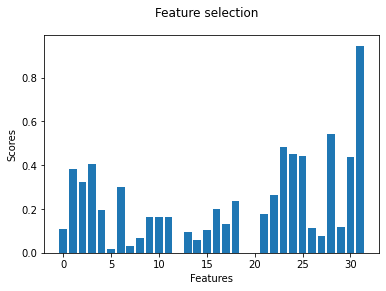

In [18]:
# Make a x and y from the dataset
x = ml_datasetenergy02[['CPI_energy1year', 'Sunhoursdaily1year', 'TG1year', 'TX1year', 'TN1year','FG_x1year','FG_y1year', 'CPI_energy2month', 'Sunhoursdaily2month', 'TG2month', 'TX2month', 'TN2month', 'FG_x2month', 'FG_y2month', 'CPI_energy3month', 'Sunhoursdaily3month', 'TG3month', 'TX3month', 'TN3month', 'FG_x3month', 'FG_y3month', 'CPI_energy6month', 'Sunhoursdaily6month', 'TG6month', 'TX6month', 'TN6month', 'FG_x6month', 'FG_y6month','Energyconsumption2month', 'Energyconsumption3month', 'Energyconsumption6month','Energyconsumption1year']]
y = ml_datasetenergy02['Energyconsumption']

# Split the dataset in training- and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

# Make the regressionmodel 
regressionmodel = LinearRegression()
regressionmodel.fit(x_train, y_train)

# Define the feature selection 
def select_features(x_train, y_train, x_test):
    future_selection01 = SelectKBest(score_func=mutual_info_regression, k='all') # Get all the features
    future_selection01.fit(x_train, y_train) # Important: see the relationship in the training data
    x_train_future_selection01 = future_selection01.transform(x_train)
    x_test_future_selection01 = future_selection01.transform(x_test)
    return x_train_future_selection01, x_test_future_selection01, future_selection01

# Get the feature selection
x_train_future_selection01, x_test_future_selection01, future_selection01 = select_features(x_train, y_train, x_test)

# Get the scores of the features
for i in range(len(future_selection01.scores_)):
    print('Feature %d: %f' % (i, future_selection01.scores_[i]))

# Show the scores in a plot

fig = plt.figure()

plt.bar([i for i in range(len(future_selection01.scores_))], future_selection01.scores_)

fig.suptitle('Feature selection')
plt.xlabel('Features')
plt.ylabel('Scores')

plt.show()


Interestingly, the features based on correlation are almost the same as features based on mutual information. However, four are different. These are features 9, 10, 16 and 21, which are included in the decission tree but were not included in linear regression. 

#### Prediction with the 17 best features

In [19]:
# Import packages 
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

# Create a x and y for the prediction. x is with the best 17 features
x = ml_datasetenergy02[['Energyconsumption1year', 'TX1year', 'TG6month', 'TX6month', 'Sunhoursdaily1year', 'TN6month', 'TG1year', 'Sunhoursdaily6month', 'Energyconsumption2month', 'TN1year', 'Energyconsumption6month', 'FG_y1year', 'TG3month', 'CPI_energy6month', 'TX2month', 'TN3month', 'TG2month']]
y = ml_datasetenergy02['Energyconsumption']  # target variable

# Make a train- and test set
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.35, random_state = 0)

# Create the model
x_standard_scaler = StandardScaler()
x_train = x_standard_scaler.fit_transform(x_train)

regrassor = DecisionTreeRegressor(random_state = 0)
regrassor.fit(x_train, y_train)

prediction_decisiontree = regrassor.predict(x_standard_scaler.transform(x_test))

# Evualate the model
print(mean_squared_error(y_test, prediction_decisiontree)**(1/2))
print(r2_score(y_test, prediction_decisiontree))

237.00199117354418
0.842081681499296


#### Predict with all the features

In [20]:
# Create a x and y for the prediction. x is with all the features
x = ml_datasetenergy02[['CPI_energy1year', 'Sunhoursdaily1year', 'TG1year', 'TX1year', 'TN1year','FG_x1year','FG_y1year', 'CPI_energy2month', 'Sunhoursdaily2month', 'TG2month', 'TX2month', 'TN2month', 'FG_x2month', 'FG_y2month', 'CPI_energy3month', 'Sunhoursdaily3month', 'TG3month', 'TX3month', 'TN3month', 'FG_x3month', 'FG_y3month', 'CPI_energy6month', 'Sunhoursdaily6month', 'TG6month', 'TX6month', 'TN6month', 'FG_x6month', 'FG_y6month','Energyconsumption2month', 'Energyconsumption3month', 'Energyconsumption6month','Energyconsumption1year']]
y = ml_datasetenergy02['Energyconsumption']

# Make a train- and test set
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.34, random_state = 0)

# Create the model
x_standard_scaler01 = StandardScaler()
x_train = x_standard_scaler01.fit_transform(x_train)

regrassor = DecisionTreeRegressor(random_state = 0)
regrassor.fit(x_train, y_train)

prediction_decisiontree01 = regrassor.predict(x_standard_scaler01.transform(x_test))

# Evualate the model
print(mean_squared_error(y_test, prediction_decisiontree01)**(1/2))
print(r2_score(y_test, prediction_decisiontree01))

256.26199347996493
0.8168064277558647


#### Conclusion decision tree regression

Even with the ideal features and number of features, the model does not perform as well as a simple calculation based on last year's energy consumption. This is because the mean squared error is about 237 and should then be lower than 198. The model does perform better than when all features are included. This means that the feature selection did make sense. The model also performed no better than the linear regression model.  

### Random forest regression

In a random forest, multiple decision trees are combined into a random forest. A random forest can potentially offer an advantage in prediction because not all variables are correlated to each other (IBM, z.d.). 

#### Make a random forest from the 17 features

In [21]:
# Import packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification

# Create a x and y for the prediction. x is with the best 17 features
x = ml_datasetenergy02[['Energyconsumption1year', 'TX1year', 'TG6month', 'TX6month', 'Sunhoursdaily1year', 'TN6month', 'TG1year', 'Sunhoursdaily6month', 'Energyconsumption2month', 'TN1year', 'Energyconsumption6month', 'FG_y1year', 'TG3month', 'CPI_energy6month', 'TX2month', 'TN3month', 'TG2month']]
y = ml_datasetenergy02['Energyconsumption']  # target variable

# Make a train- and test set
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.34, random_state = 0)

# Create the model
random_forest = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 18).fit(x_train, y_train)

prediction_random_forest = random_forest.predict(x_test)

# Evualate the model
print(mean_squared_error(y_test, prediction_random_forest)**(1/2))
print(r2_score(y_test, prediction_random_forest))

239.520813735866
0.8399600718065101


In [22]:
# Import packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification

# Create a x and y for the prediction. x is with all the features
x = ml_datasetenergy02[['CPI_energy1year', 'Sunhoursdaily1year', 'TG1year', 'TX1year', 'TN1year','FG_x1year','FG_y1year', 'CPI_energy2month', 'Sunhoursdaily2month', 'TG2month', 'TX2month', 'TN2month', 'FG_x2month', 'FG_y2month', 'CPI_energy3month', 'Sunhoursdaily3month', 'TG3month', 'TX3month', 'TN3month', 'FG_x3month', 'FG_y3month', 'CPI_energy6month', 'Sunhoursdaily6month', 'TG6month', 'TX6month', 'TN6month', 'FG_x6month', 'FG_y6month','Energyconsumption2month', 'Energyconsumption3month', 'Energyconsumption6month','Energyconsumption1year']]
y = ml_datasetenergy02['Energyconsumption']

# Make a train- and test set
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.34, random_state = 0)

# Create the model
random_forest = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 18).fit(x_train, y_train)

prediction_random_forest = random_forest.predict(x_test)

# Evualate the model
print(mean_squared_error(y_test, prediction_random_forest)**(1/2))
print(r2_score(y_test, prediction_random_forest))

247.07125124302587
0.8297111313314719


#### Conclusion random forest regression

It is very strange that the random forest performs equally well with both. Therefore, grid research may have to take place to optimise the hyper parameters. However, it does not yet come close to linear regression. So that will not happen at this time. Several ways have been tried to change the hyper parameters. However, this did not result in a higher mean squared error. 

## Optimalise one model

The model with the best mean squared error. 

## Conclusion

Heel belangrijk : Wat nou als we meer data hadden gehad. Ik had dan time series veranderd, modellen blijven hetzelfde. 

Some conclusions:
We have no technical data at our disposal which could be useful. In another study, this proved to be fine data to apply (Ying, 2021). 

Some questions:
Which model does work the best? 

Do models with fewer features work better? 

Two options or store heat or predict. Is forecasting possible then? 

Whats the relation with the ethical problem? 
Link to my Github

## Legend

Word:      | Description:
-----------|------------
CPI:       |Consumer price index
TG:        |Mean temperature
TN:        |Maximum temperature
TX:        |Minimum temperature
TG_y:      |Wind strenght mean
TG_x:      |Wind strenght mode

## Sources:

Brownlee, J. (2020, juni 8). How to Perform Feature Selection for Regression Data. Opgeroepen op 17 oktober, 2022, van Machine Learning Mastery: https://machinelearningmastery.com/feature-selection-for-regression-data/

Buijze, A. (2021). “Power to the People”. Utrecht: Universiteit Utrecht.

Ding, Y. (2021). Energy & Buildings. Chongqing: Elsevier.

Het Weer. (2022, z.d. z.d.). nvloed van het weer op de energierekening. Opgeroepen op oktober 16, 2022, van Het Weer: https://hetweermagazine.nl/artikelen/invloed-van-het-weer-op-de-energierekening#:~:text=Als%20de%20buitentemperatuur%20gemiddeld%20hoger,zon%20en%20mate%20van%20isolatie.

Heyes, A. (2022, mei 27). Understanding Purchasing Power and the Consumer Price Index. Opgeroepen op september 29, 2022, van Investopedia: https://www.investopedia.com/terms/p/purchasingpower.asp

IBM. (2020, december 7). Random Forest. Opgeroepen op oktober 7, 2022, van IBM: https://www.ibm.com/cloud/learn/random-forest

Kamer, T. (2022, mei 22). Debat over de ontwikkeling van de koopkracht en de stijgende energieprijzen, eerste termijn Kamer. Opgeroepen op september 20, 2022, van Tweede Kamer: https://www.tweedekamer.nl/kamerstukken/plenaire_verslagen/kamer_in_het_kort/debat-over-de-ontwikkeling-van-de-koopkracht-en-de

Knaub, J. R. (2015). When Prediction is Not Time Series Forecasting. ResearchGate.

KNMI. (z.d., z.d. z.d.). Windschaal van Beaufort. Opgeroepen op september 19, 2022, van KNMI: https://www.knmi.nl/kennis-en-datacentrum/uitleg/windschaal-van-beaufort

Rijksoverheid. (2022, september 16). Nederland maakt ambitie wind op zee bekend: 70 gigawatt in 2050. Opgeroepen op september 19, 2022, van Rijksoverheid: https://www.rijksoverheid.nl/actueel/nieuws/2022/09/16/nederland-maakt-ambitie-wind-op-zee-bekend-70-gigawatt-in-2050

Seldon. (2021, november 13). Decision Trees in Machine Learning Explained. Opgeroepen op oktober 19, 2022, van Seldon: https://www.seldon.io/decision-trees-in-machinelearning#:~:text=Decision%20trees%20are%20an%20approach,categorise%20or%20classify%20an%20object.

Solutions, S. (z.d., z.d. z.d.). What is Linear Regression? Opgeroepen op oktober 19, 2022, van Statistics Solutions: https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/what-is-linear-regression/

Visser, M. (2014). Duurzaam Groningen in 2035. Groningen: Hanze University of Applied Sciences Groningen.

Weezel, T. G. (2022, mei 30). Recordreeks van groene stroom leidt tot nieuwe problemen voor producenten en netbeheerder. Opgeroepen op september 20, 2022, van de Volkskrant: volkskrant.nl/economie/recordreeks-van-groene-stroom-leidt-tot-nieuwe-problemen-voor-producenten-en-netbeheerder~b707ed72/?referrer=https%3A%2F%2Fwww.google.com%2F

Wolters, D. (2011). Ruimtelijke klimatologische verschillen binnen Nederland. De Bilt: KNMI.

Zhao, D. (2019). Effective Features to Predict Residential Energy Consumption Using Machine Learning. Michigan: ResearchGate.

